# Ежедневные значения курса USD в BLR с 2018, взяты с сайта nbrb. Простите за txt файл :) 

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [2]:
values_str = None
with open("USD.txt","r") as r:
    values_str = r.read().splitlines()
series = [float(i) for i in values_str]

In [3]:
# проверка стационарности Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Time-series plot
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        # qqplot для определения нормальности распределения остатков
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
# проверим на старте:

Results of Dickey-Fuller Test:
Test Statistic                   -0.388681
p-value                           0.911972
#Lags Used                       17.000000
Number of Observations Used    1129.000000
Critical Value (1%)              -3.436155
Critical Value (5%)              -2.864103
Critical Value (10%)             -2.568135
dtype: float64


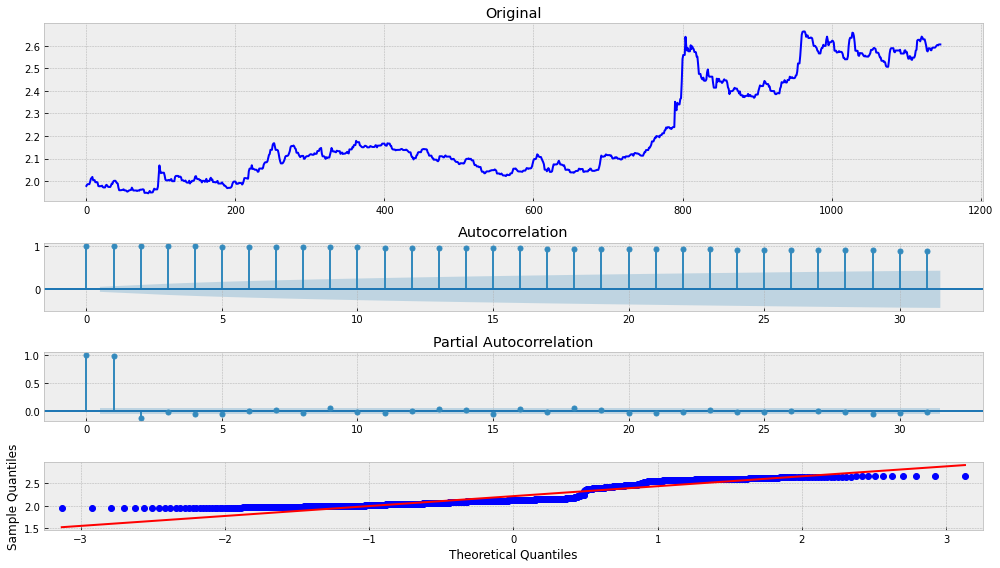

In [5]:
tsplot(series)

### резкий взлет приходятся на начало 2020 года - старта пандемии коронавируса
в идеале рассматривать до и после, так и поступим(но рассмотрим только после)
возьмем середину начало марта 2020 за старт

In [6]:
series20_21 = series[800:]

Results of Dickey-Fuller Test:
Test Statistic                  -1.595298
p-value                          0.485955
#Lags Used                       1.000000
Number of Observations Used    345.000000
Critical Value (1%)             -3.449447
Critical Value (5%)             -2.869954
Critical Value (10%)            -2.571253
dtype: float64


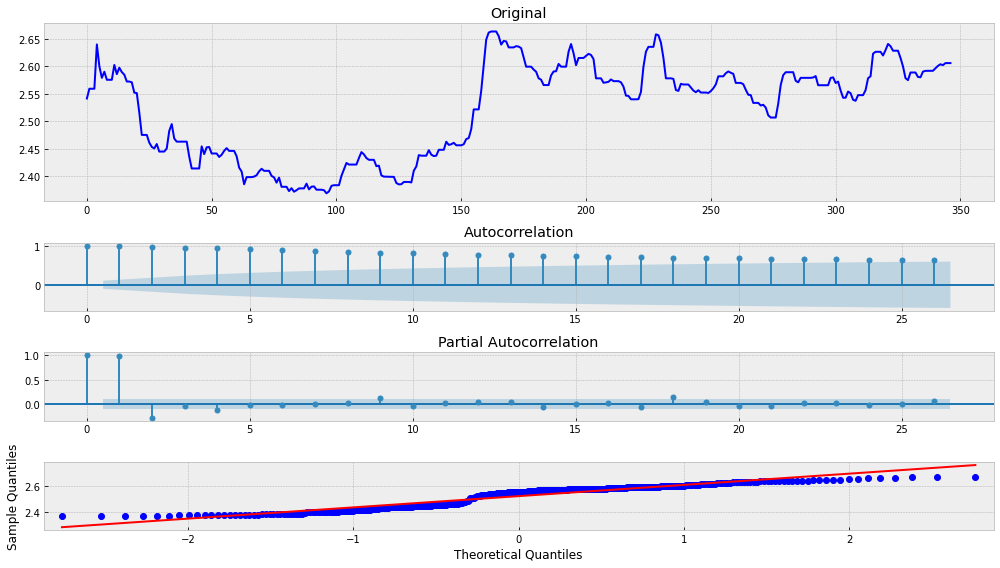

In [7]:
tsplot(series20_21)

Results of Dickey-Fuller Test:
Test Statistic                -8.216230e+00
p-value                        6.612859e-13
#Lags Used                     1.400000e+01
Number of Observations Used    3.300000e+02
Critical Value (1%)           -3.450322e+00
Critical Value (5%)           -2.870338e+00
Critical Value (10%)          -2.571458e+00
dtype: float64


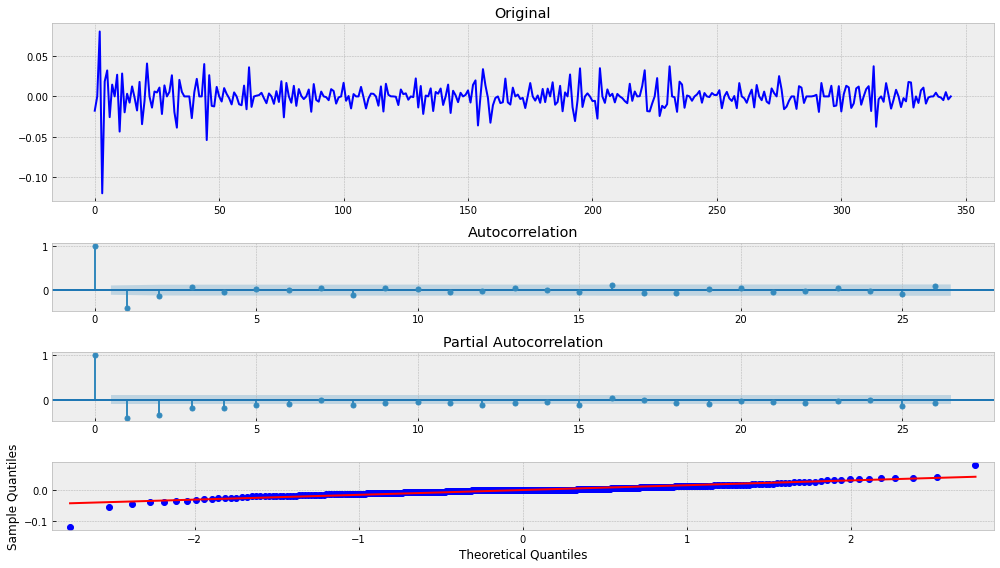

In [8]:
series_upd = boxcox(series20_21,1)
series_upd = np.diff(series_upd)

series_upd = np.diff(series_upd)

tsplot(series_upd)

In [9]:
# теперь ряд можем считать стационарным, начем строить модели 

In [10]:
# def _get_best_model(TS):
#     best_aic = np.inf 
#     best_order = None
#     best_mdl = None

#     for i in range(0,6):
#         for d in range(0,6):
#             for j in range(0,6):
#                 try:
#                     tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
#                         method='mle', trend='nc'
#                     )
#                     tmp_aic = tmp_mdl.aic
#                     if tmp_aic < best_aic:
#                         best_aic = tmp_aic
#                         best_order = (i, d, j)
#                         best_mdl = tmp_mdl
#                 except: continue
#     print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
#     return best_aic, best_order, best_mdl

# aic, order, mdl = _get_best_model(series_upd)

# ARIMA

In [11]:
arima_model = smt.ARIMA(series_upd, order=(5,0,3)).fit(method='mle', trend='nc')

Results of Dickey-Fuller Test:
Test Statistic                 -18.915032
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64


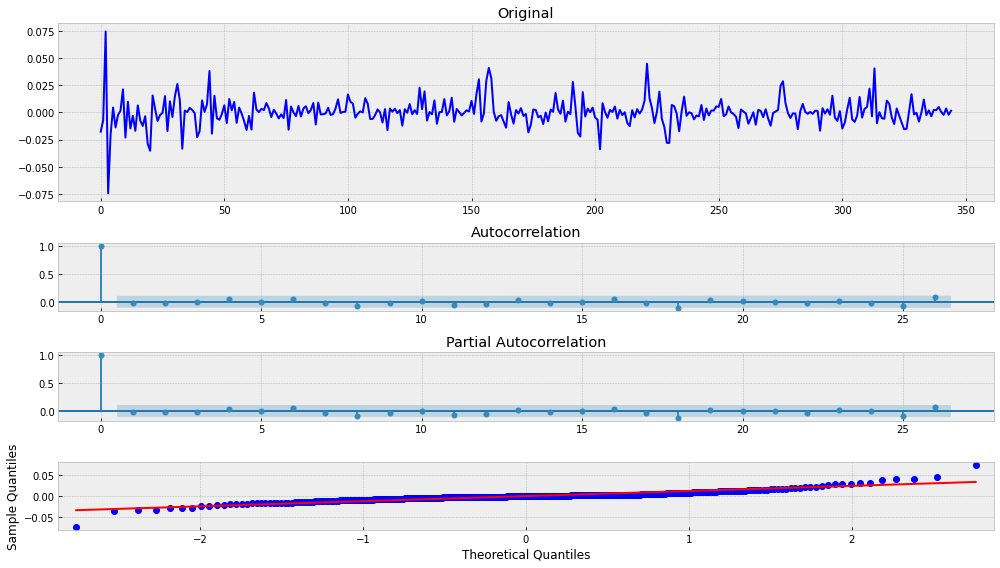

In [12]:
tsplot(arima_model.resid)

In [13]:
# попробуем обучиться на len-20 Значениях и предсказать оставшиеся 20

In [14]:
arima_model = smt.ARIMA(series_upd[:-21], order=(5,0,3)).fit(method='mle', trend='nc')

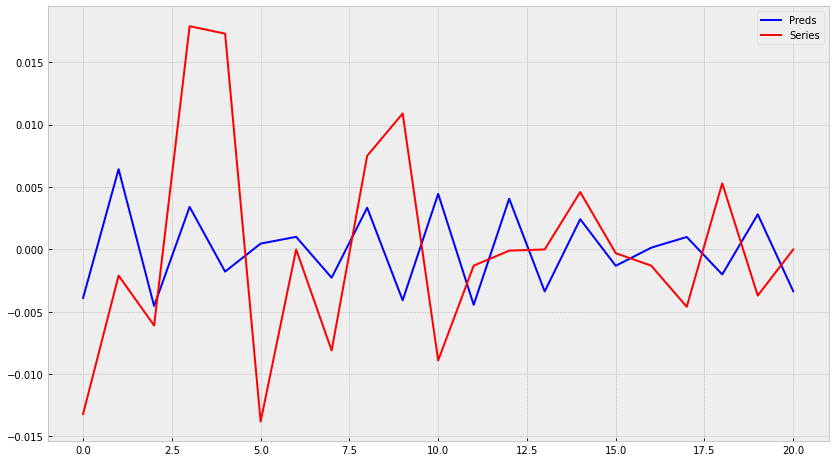

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(arima_model.predict(len(series_upd[:-21]),len(series_upd[:-21])+20),color="blue",label='Preds')
    plt.plot(series_upd[-21:], color='red', label='Series')
    plt.legend()
    plt.show()

In [16]:
print("RMSE :" + str(np.sqrt(np.sum((arima_model.predict(len(series_upd[:-21]),len(series_upd[:-21])+20)-series_upd[-21:])**2))/20))

RMSE :0.001987012750265666


# GARCH

In [17]:
from arch import arch_model
am = arch_model(series_upd, p=5, o=0, q=3, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1002.54
Distribution:      Standardized Student's t   AIC:                          -1983.07
Method:                  Maximum Likelihood   BIC:                          -1940.79
                                              No. Observations:                  345
Date:                      Sun, Feb 28 2021   Df Residuals:                      344
Time:                              23:02:35   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -8.216230e+00
p-value                        6.612859e-13
#Lags Used                     1.400000e+01
Number of Observations Used    3.300000e+02
Critical Value (1%)           -3.450322e+00
Critical Value (5%)           -2.870338e+00
Critical Value (10%)          -2.571458e+00
dtype: float64


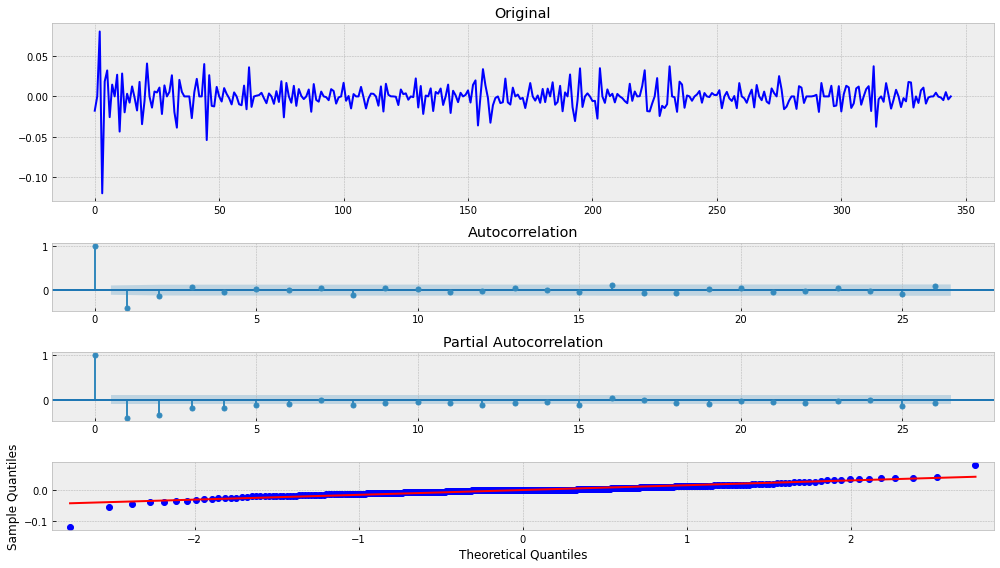

In [18]:
tsplot(res.resid)

# Lovely classic ML

In [19]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy(),columns=["Count"])
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data["Count"].shift(i)
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = prepareData(series20_21, lag_start=1, lag_end=25, test_size=0.25)

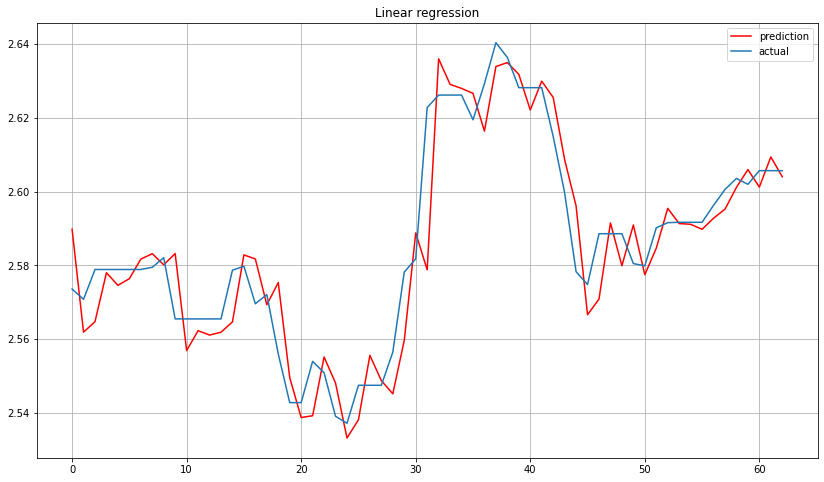

In [21]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [22]:
print("RMSE :" + str(np.sqrt(np.sum((prediction-y_test)**2))/y_test.shape[0]))

RMSE :0.001272465254070159


In [23]:
# try to predict for the next 10 days

In [24]:
to_pred = X_test.shift(10).iloc[-10:]

In [25]:
lr.predict(to_pred)

array([2.60870752, 2.59613035, 2.56662616, 2.57088301, 2.59152551,
       2.57991529, 2.59096584, 2.57746757, 2.58466934, 2.59546997])

In [26]:
# try to buy some USD this week I think)))))

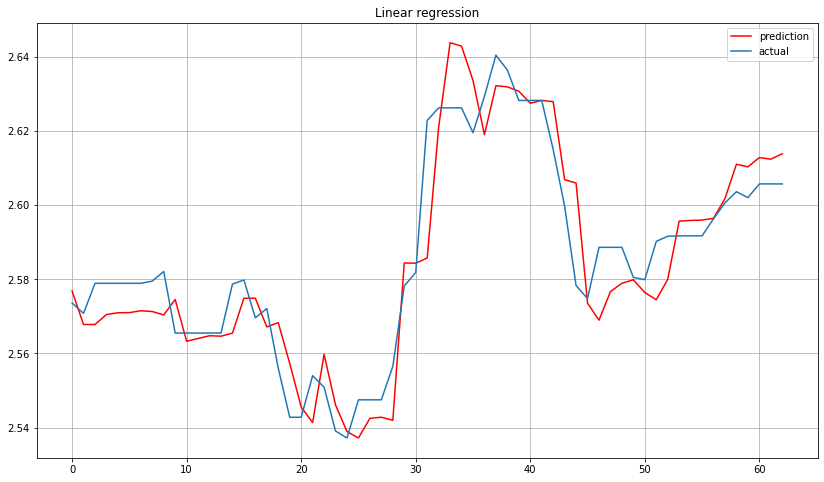

In [27]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=120,n_jobs=-1)
rfc.fit(X_train,y_train)
prediction = rfc.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [28]:
print("RMSE :" + str(np.sqrt(np.sum((prediction-y_test)**2))/y_test.shape[0]))

RMSE :0.0013025133891126275


# HMM

In [29]:
from hmmlearn.hmm import GaussianHMM
series20_21= np.array(series20_21)
series20_21 = series20_21.reshape(-1,1)
# for n in range(1, 18):
#     model = GaussianHMM(n_components=n,
#                         covariance_type="diag",
#                         n_iter=1000)
#     model.fit(series20_21)
#     print (n, model.score(series20_21)) # score - это правдоподобие модели

In [30]:
model = GaussianHMM(n_components=15,covariance_type="diag", n_iter=1000)

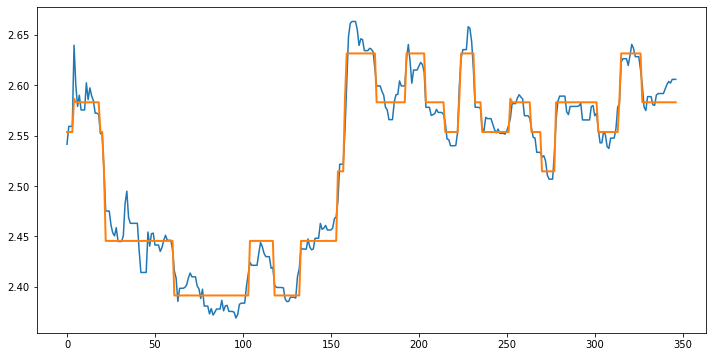

In [31]:
model.fit(series20_21)
labels = model.predict(series20_21)
means = np.zeros_like(series20_21)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(series20_21)
plt.plot(means, linewidth=2)

In [32]:
test_index = series20_21.shape[0] - 20

In [33]:
train = series20_21[:test_index]
test = series20_21[test_index:]

In [34]:
model = GaussianHMM(n_components=15,
                        covariance_type="diag",
                        n_iter=1500)
model.fit(train)

GaussianHMM(n_components=15, n_iter=1500)

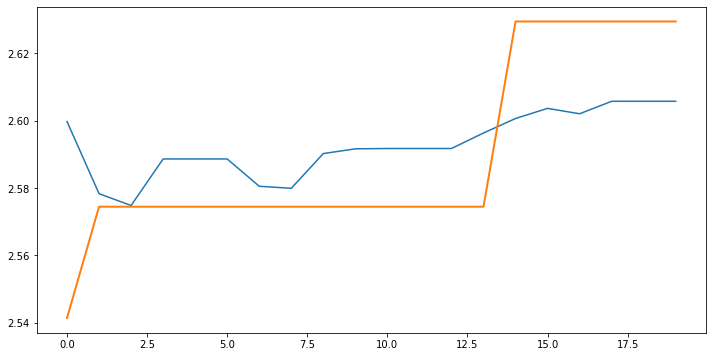

In [35]:
labels = model.predict(test)
means = np.zeros_like(test)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(test)
plt.plot(means, linewidth=2)

In [36]:
print("RMSE : ")
print(np.sqrt(np.sum((means-test)**2))/test.shape[0])

RMSE : 
0.004978668873914271


In [37]:
# linear regression - best one 